In [13]:
import os
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from collections import Counter
from scipy.sparse.csr import csr_matrix
import numpy as np

In [2]:
rootdir = 'BBC News Articles'
data_list = []
data = pd.DataFrame()
i = 1
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        file = open(os.path.join(subdir, file), encoding='utf-8')
        line = file.read().replace("\n","")
        ##convert each line to lowercase
        data.set_value(i,'ArticleType',subdir.rsplit("\\")[-1])
        data.set_value(i,'Article',line.lower())
        file.close()
        i+=1
#data.to_csv("BBCNewsArticles.csv",index=False)
#data['Articlenopunctuations'] = data['Article'].str.replace("[.,]","")
#data['Articlenopunctuations'] = data['Article'].str.replace("['']"," ")

##Remove punctuations,numbers
data['Articlenopunctuations'] = data['Article'].str.replace("[^a-zA-Z\s]"," ")
stop = stopwords.words('english')
ps = PorterStemmer()

C:\Users\SP.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\SP.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [3]:
##Remove stopwords
data['Articlenostopwords']= data['Articlenopunctuations'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Stemming
data['Articlepreprocessed'] = data['Articlenostopwords'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

##Convert preprocessed(no punctuations, no stop words, stemmed, lowercase, no blanklines) articles to tokens
data['Articletokens'] = data['Articlepreprocessed'].apply(word_tokenize)
data['ArticleType_id'] = data['ArticleType'].factorize()[0]
#data.to_csv("BBCNewsArticles.csv",index=False)

In [4]:
###Analysis
##Code below spits out most frequent words with its count present in each document category
for group_name, subset in data.groupby('ArticleType'):
    sentimentData=subset['Articlepreprocessed']
    words=[]
    for each in sentimentData:
        words.extend(each.split(" "))
    print(group_name)
    print(Counter(words).most_common(15))
    print()
##
###

business
[('said', 96), ('year', 65), ('bn', 51), ('us', 48), ('growth', 38), ('firm', 35), ('govern', 35), ('job', 34), ('compani', 33), ('call', 33), ('market', 30), ('would', 30), ('price', 28), ('report', 26), ('could', 26)]

entertainment
[('film', 91), ('said', 72), ('award', 65), ('best', 62), ('year', 59), ('book', 57), ('includ', 40), ('star', 37), ('work', 34), ('ballet', 32), ('new', 31), ('winner', 31), ('also', 28), ('one', 26), ('novel', 26)]

politics
[('said', 149), ('mr', 119), ('would', 69), ('govern', 59), ('say', 51), ('blair', 50), ('labour', 44), ('minist', 39), ('tori', 37), ('plan', 34), ('women', 32), ('parti', 32), ('elect', 30), ('new', 29), ('e', 29)]

sport
[('year', 85), ('world', 76), ('athlet', 64), ('said', 59), ('olymp', 54), ('race', 41), ('indoor', 38), ('athen', 38), ('time', 37), ('champion', 35), ('also', 34), ('record', 29), ('last', 28), ('championship', 27), ('win', 26)]

tech
[('said', 176), ('use', 142), ('peopl', 84), ('mobil', 68), ('one', 

In [5]:
##Prepare labels##
articletype = data[['ArticleType','ArticleType_id']].drop_duplicates().sort_values('ArticleType_id')
category_to_id = dict(articletype.values)
id_to_category = dict(articletype[['ArticleType_id','ArticleType']].values)
print(id_to_category)
print(articletype)
print(category_to_id)
#exit
##

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
       ArticleType  ArticleType_id
1         business               0
35   entertainment               1
74        politics               2
104          sport               3
139           tech               4
{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}


In [6]:
all_words = []
for i in data['Articletokens']:
    for j in i:
        all_words.append(j)
corpus_tokens = list(set(all_words))
print(corpus_tokens)

detokenizelist = []
detokenizer = TreebankWordDetokenizer()
for k in data['Articletokens']:
        detokenizelist.append(detokenizer.detokenize(k))
print(detokenizelist)

number_of_clusters=5

['dutchman', 'giusepp', 'greenback', 'credenti', 'flash', 'tight', 'insid', 'depict', 'joey', 'purchas', 'sitea', 'stay', 'incens', 'takeov', 'export', 'hastili', 'leipzig', 'imaginari', 'oscar', 'ciphertrust', 'driven', 'mp', 'cojed', 'includ', 'slip', 'endless', 'flown', 'paddi', 'law', 'rite', 'requir', 'troop', 'neeson', 'quicker', 'beam', 'survey', 'dissid', 'approxim', 'straight', 'cornerston', 'sing', 'weekend', 'renown', 'miscount', 'gala', 'fog', 'ran', 'impati', 'herebi', 'vapourwar', 'jobsmitt', 'younger', 'counter', 'ixi', 'architectur', 'concern', 'christin', 'wizard', 'sach', 'slight', 'lap', 'warm', 'haisheng', 'egalitarian', 'fundhalf', 'supplement', 'visibl', 'power', 'scant', 'paisley', 'lift', 'khodorkovski', 'pink', 'chapter', 'jamaican', 'savag', 'ncb', 'upward', 'senn', 'keyboard', 'ground', 'dayanidhi', 'trevor', 'enthusiasm', 'pyongyang', 'mostli', 'thai', 'dispens', 'perua', 'peru', 'clair', 'typic', 'whatev', 'lausann', 'throughput', 'patrol', 'havana', 'ira',

In [18]:
np.array(articlepavector[0]).reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [29]:
'''PresenceAbsence Vector'''
articlepavector = []
datat=[]
indices = []
for j in data['Article']:
    vector = []
    for k in j:
        if(k in corpus_tokens):
            vector.append(1)
        else:
            vector.append(0)
    articlepavector.append(vector)
articlepavector = np.array(articlepavector[0]).reshape(-1,1)
pca = PCA(n_components=1).fit(articlepavector)
data2Dpav = pca.transform(articlepavector)

km = KMeans(n_clusters=number_of_clusters)
km.fit(articlepavector)
# pd.crosstab(km.labels_, data["Articlepreprocessed"])
# label = kmcountvector.predict(X_counts)
print(f'Silhouette Score(n=5): {silhouette_score(articlepavector, km.labels_)}')

C:\Users\SP.000\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.


Silhouette Score(n=5): 1.0


Silhouette Score(n=5): 0.308


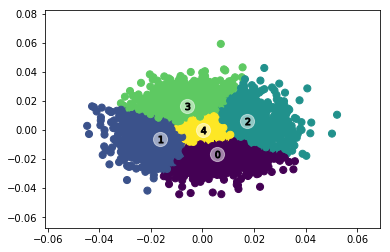

In [8]:
'''Count Vector'''
countvector = CountVectorizer()
X_counts = countvector.fit_transform(corpus_tokens).todense()
X_names = countvector.get_feature_names()

pcacv = PCA(n_components=2).fit(X_counts)
data2Dcv = pcacv.transform(X_counts) 

kmcountvector = KMeans(n_clusters=number_of_clusters)
kmcountvector.fit(data2Dcv)
labelcsv = pd.DataFrame(kmcountvector.labels_).to_csv("BBCNewsArticlesClustered.csv")

plt.figure(1)
plt.scatter(data2Dcv[:, 0], data2Dcv[:, 1], c=kmcountvector.labels_, s=50, cmap='viridis')
centers = kmcountvector.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=0.5)
for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
print('Silhouette Score(n=5): %0.3f'% silhouette_score(data2Dcv, kmcountvector.labels_))

Silhouette Score(n=5): 0.538


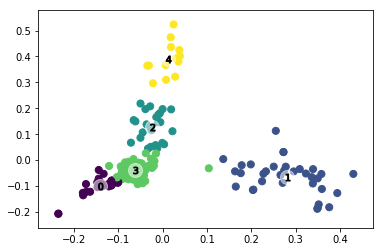

In [9]:
'''TFID VECTOR'''
tf_vect = TfidfVectorizer()
tf_matrix = tf_vect.fit_transform(detokenizelist).todense()
tf_names = tf_vect.get_feature_names()

pca = PCA(n_components=2).fit(tf_matrix)
data2D = pca.transform(tf_matrix)  

kmtfvect = KMeans(n_clusters=number_of_clusters)
kmtfvect.fit(data2D)
labelcsv = pd.DataFrame(kmtfvect.labels_).to_csv("BBCNewsArticlesClustered.csv",mode='a')
plt.figure(2)
plt.scatter(data2D[:, 0], data2D[:, 1], c=kmtfvect.labels_, s=50, cmap='viridis')
centers = kmtfvect.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=0.5)
for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
print('Silhouette Score(n=5): %0.3f'% silhouette_score(data2D, kmtfvect.labels_))

In [ ]:
'''
Provide your explanation for the following questions 
1.What does Silhouette Coefficient tell us?
Ans: Silhouette Coefficient's are calculated based on mean intra-cluster 
distance and nearest cluster distance distance between each sample. It is measured
between -1 to +1 closer the values to +1 means samples are assigned to accurate/appropriate
clusters. 

2.Which algorithm you chose and why?
Ans: I chose Kmeans algorithm as that is simpliest unsupervised clustering algorithm.
which forms clusters based passed n_clusters.one of the fastest clustering algorithms available

3.Can you provide an appropriate name to a cluster label? 
If yes, then explain your observations.
Yes According to the figure here is the cluster mapping (0 -> business),(1 -> entertainment)
(2->politics), (3->sports) (4->tech)
4.Which vectorization technique is the best and why?
Ans: TF-IDF no doubt as it tokenizes words on its own after passsing list of string to it.
Term Frequency - Inverse Document Frequency is widely used in clustering for classification of documents.
removes all duplicates and scales down the tokens which are less informative and occur more frequently
'''